<a href="https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit8/unit8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8: Proximal Policy Gradient (PPO) with PyTorch 🤖

In this unit, you'll learn to **code your PPO agent from scratch with PyTorch**.

To test its robustness, we're going to train it in 2 different classical environments:

- [Cartpole-v1](https://www.gymlibrary.ml/environments/classic_control/cart_pole/?highlight=cartpole)
- [LunarLander-v2 🚀](https://www.gymlibrary.ml/environments/box2d/lunar_lander/)

We finish this foundations part of the course by **understanding how PPO works deeply.** In the first Unit, you learned to train a PPO agent on LunarLander-v2. And now, with Unit 8, you can code it from scratch. **How incredible is that 🤩.**

![cover](https://pbs.twimg.com/media/FOtG8d8XoAEEQXw.jpg)


⬇️ Here is an example of what you will achieve. ⬇️

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/sb3/ppo-CartPole-v1/resolve/main/replay.mp4" type="video/mp4"></video>

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/sb3/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

💡 We advise you to use Google Colab since some environments work only with Ubuntu. The free version of Google Colab is perfect for this tutorial. Let's get started 🚀

## This notebook is from Deep Reinforcement Learning Class

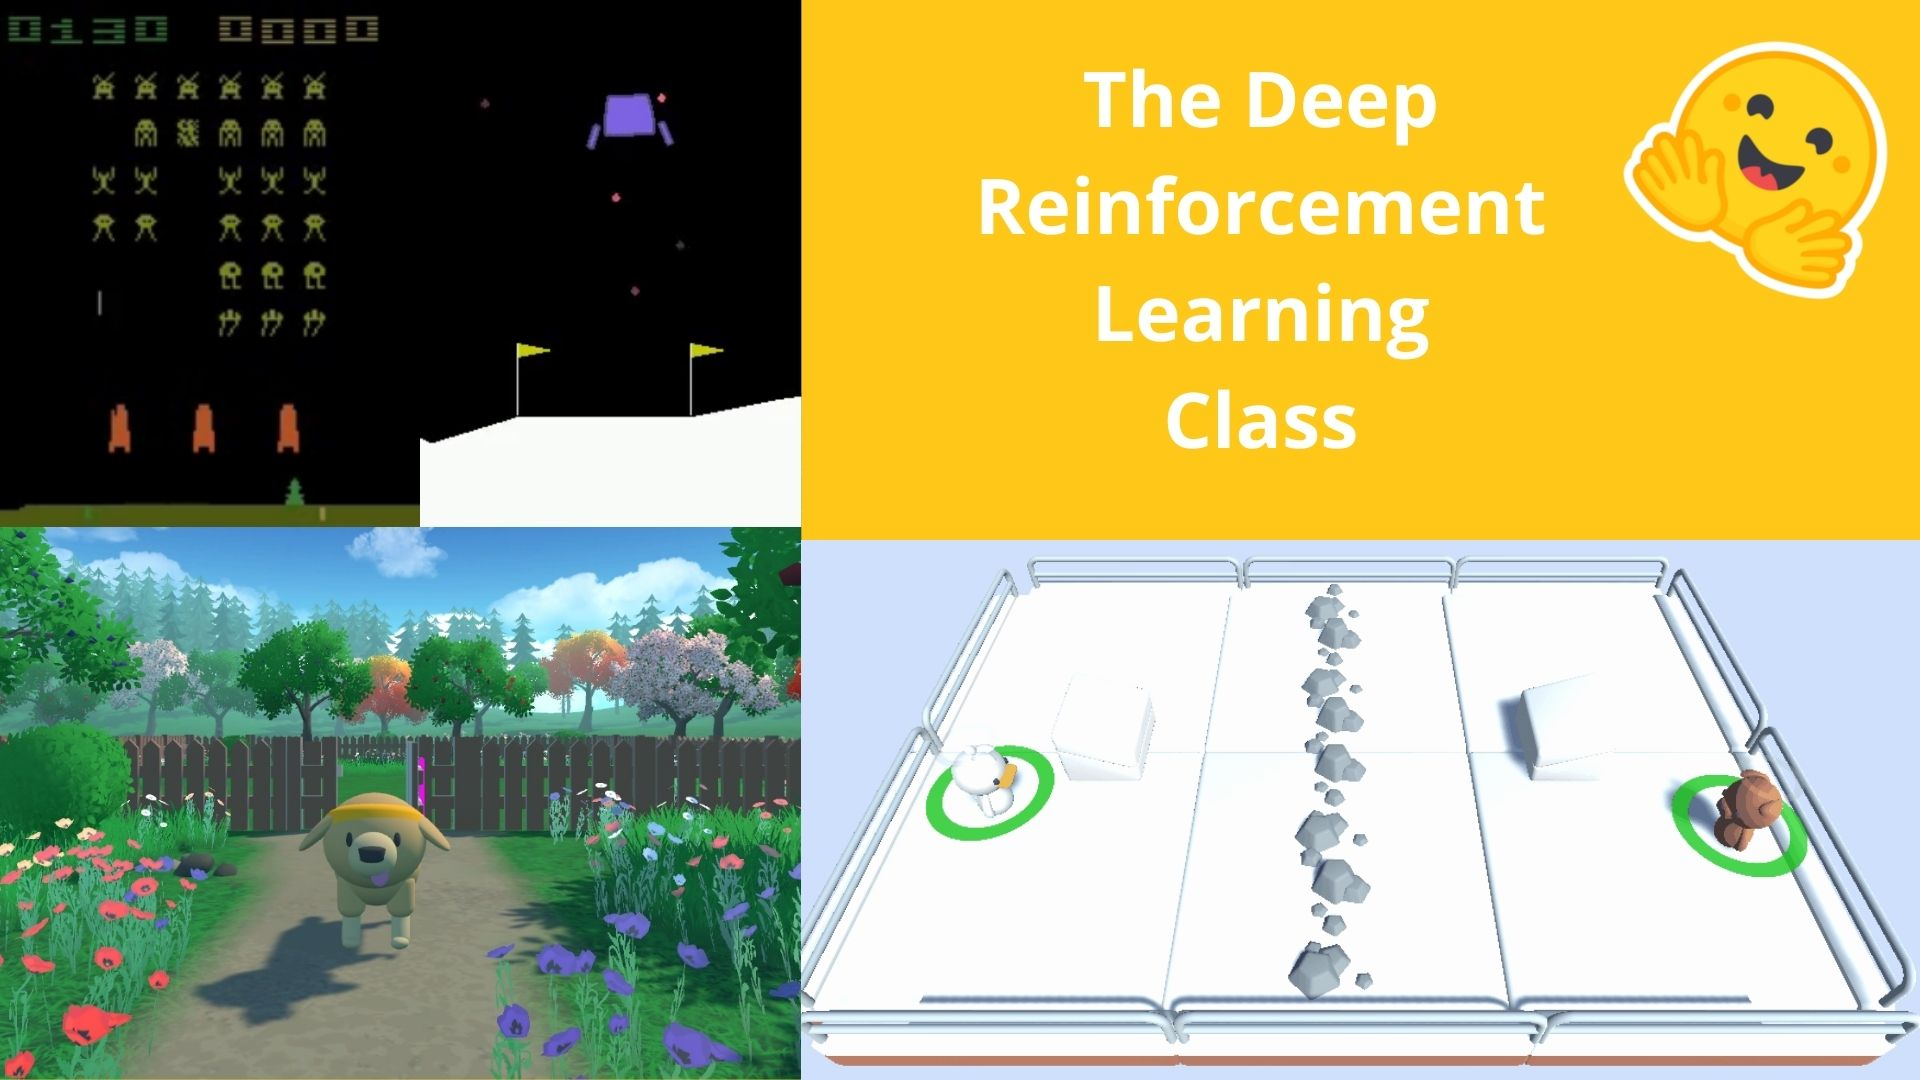

In this free course, you will:

- 📖 Study Deep Reinforcement Learning in **theory and practice**.
- 🧑‍💻 Learn to **use famous Deep RL libraries** such as Stable Baselines3, RL Baselines3 Zoo, and RLlib.
- 🤖 Train **agents in unique environments** 

And more check 📚 the syllabus 👉 https://github.com/huggingface/deep-rl-class

The best way to keep in touch is to join our discord server to exchange with the community and with us 👉🏻 https://discord.gg/aYka4Yhff9

## Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Read the Unit 8 Readme](https://github.com/huggingface/deep-rl-class/blob/main/unit8/README.md) contains all the information.

🔲 📚 **Study Proximal Policy Optimization (PPO)** by reading the chapter 👉 https://huggingface.co/blog/deep-rl-ppo

### Step 0: Set the GPU 💪
- To **faster the agent's training, we'll use a GPU** to do that go to `Runtime > Change Runtime type`
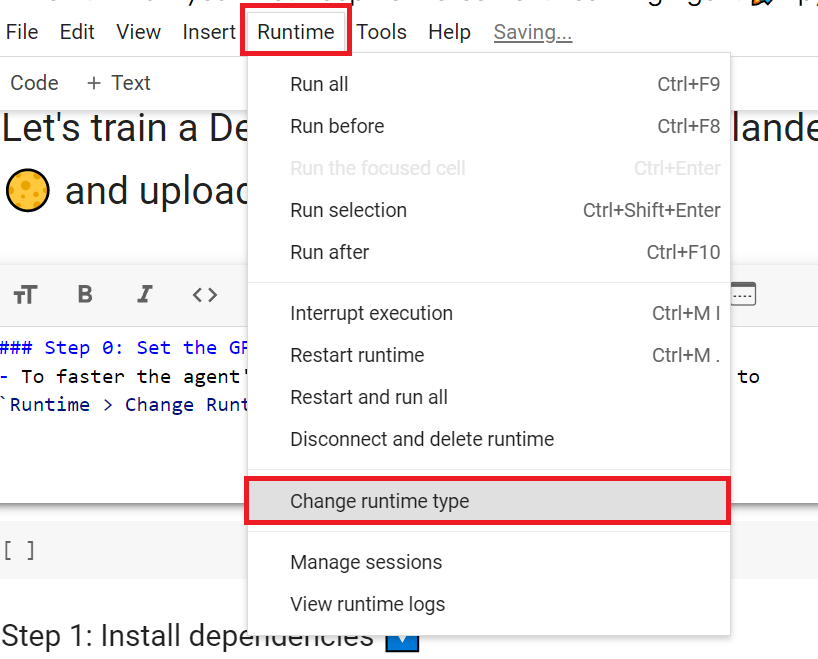


- `Hardware Accelerator > GPU`

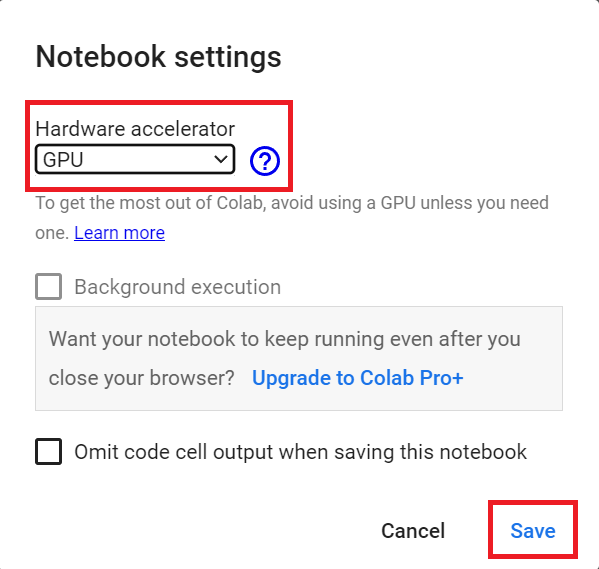

### Step 1: Install dependencies 🔽 and virtual screen 💻


In [ ]:
!pip install imageio-ffmpeg
!pip install huggingface_hub
!pip install gym[box2d]

In [ ]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(500, 500))
virtual_display.start()

### Step 2: Let's code PPO from scratch with Costa Huang tutorial
- For the core implementation of PPO we're going to use the excellent [Costa Huang](https://costa.sh/) tutorial.
- In addition to the tutorial, to go deeper you can read the 13 core implementation details: https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

👉 The video tutorial: https://youtu.be/MEt6rrxH8W4

In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MEt6rrxH8W4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

- The best is to code first on the cell below, this way, if you kill the machine **you don't loose the implementation**.

In [ ]:
### Your code here:

### Step 3: Add the Hugging Face Integration 🤗
- In order to push our model to the Hub, we need to define a function `package_to_hub`

- Add dependencies we need to push our model to the Hub

In [ ]:
from huggingface_hub import HfApi, upload_folder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import tempfile
import json
import shutil
import imageio

from wasabi import Printer
msg = Printer()

- Add new argument in `parse_args()` function to define the repo-id where we want to push the model.

In [ ]:
# Adding HuggingFace argument
parser.add_argument("--repo-id", type=str, default="ThomasSimonini/ppo-CartPole-v1", help="id of the model repository from the Hugging Face Hub {username/repo_name}")

- Next, we add the methods needed to push the model to the Hub

- These methods will:
  - `_evalutate_agent()`: evaluate the agent.
  - `_generate_model_card()`: generate the model card of your agent.
  - `_record_video()`: record a video of your agent.

In [ ]:
def package_to_hub(repo_id, 
                model,
                hyperparameters,
                eval_env,
                video_fps=30,
                commit_message="Push Reinforce agent to the Hub",
                token= None,
                logs=None
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the hub
  :param repo_id: id of the model repository from the Hugging Face Hub
  :param model: trained model
  :param eval_env: environment used to evaluate the agent
  :param fps: number of fps for rendering the video
  :param commit_message: commit message
  :param logs: directory on local machine of tensorboard logs you'd like to upload
  """
  msg.info(
        "This function will save, evaluate, generate a video of your agent, "
        "create a model card and push everything to the hub. "
        "It might take up to 1min. \n "
        "This is a work in progress: if you encounter a bug, please open an issue."
    )
  # Step 1: Clone or create the repo
  repo_url = HfApi().create_repo(
        repo_id=repo_id,
        token=token,
        private=False,
        exist_ok=True,
    )
  
  with tempfile.TemporaryDirectory() as tmpdirname:
    tmpdirname = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model.state_dict(), tmpdirname / "model.pt")
  
    # Step 3: Evaluate the model and build JSON
    mean_reward, std_reward = _evaluate_agent(eval_env, 
                                           10, 
                                           model)

    # First get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
        "env_id": hyperparameters.env_id, 
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_evaluation_episodes": 10,
        "eval_datetime": eval_form_datetime,
    }
 
    # Write a JSON file
    with open(tmpdirname / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

    # Step 4: Generate a video
    video_path =  tmpdirname / "replay.mp4"
    record_video(eval_env, model, video_path, video_fps)
  
    # Step 5: Generate the model card
    generated_model_card, metadata = _generate_model_card("PPO", hyperparameters.env_id, mean_reward, std_reward, hyperparameters)
    _save_model_card(tmpdirname, generated_model_card, metadata)

    # Step 6: Add logs if needed
    if logs:
      _add_logdir(tmpdirname, Path(logs))
  
    msg.info(f"Pushing repo {repo_id} to the Hugging Face Hub")
  
    repo_url = upload_folder(
            repo_id=repo_id,
            folder_path=tmpdirname,
            path_in_repo="",
            commit_message=commit_message,
            token=token,
        )

    msg.info(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")
  return repo_url

def _evaluate_agent(env, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    while done is False:
      state = torch.Tensor(state)
      action, _, _, _ = policy.get_action_and_value(state)
      new_state, reward, done, info = env.step(action.numpy())
      total_rewards_ep += reward    
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

def record_video(env, policy, out_directory, fps=30):
  images = []  
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    state = torch.Tensor(state)
    # Take the action (index) that have the maximum expected future reward given that state
    action, _, _, _  = policy.get_action_and_value(state)
    state, reward, done, info = env.step(action.numpy()) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def _generate_model_card(model_name, env_id, mean_reward, std_reward, hyperparameters):
  """
  Generate the model card for the Hub
  :param model_name: name of the model
  :env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  :hyperparameters: training arguments
  """
  # Step 1: Select the tags
  metadata = generate_metadata(model_name, env_id, mean_reward, std_reward)

  # Transform the hyperparams namespace to string
  converted_dict = vars(hyperparameters)
  converted_str = str(converted_dict)
  converted_str = converted_str.split(", ")
  converted_str = '\n'.join(converted_str)
 
  # Step 2: Generate the model card
  model_card = f"""
  # PPO Agent Playing {env_id}

  This is a trained model of a PPO agent playing {env_id}.
  To learn to code your own PPO agent and train it Unit 8 of the Deep Reinforcement Learning Class: https://github.com/huggingface/deep-rl-class/tree/main/unit8
  
  # Hyperparameters
  ```python
  {converted_str}
  ```
  """
  return model_card, metadata

def generate_metadata(model_name, env_id, mean_reward, std_reward):
  """
  Define the tags for the model card
  :param model_name: name of the model
  :param env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  """
  metadata = {}
  metadata["tags"] = [
        env_id,
        "ppo",
        "deep-reinforcement-learning",
        "reinforcement-learning",
        "custom-implementation",
        "deep-rl-class"
  ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=model_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_id,
      dataset_id=env_id,
  )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  return metadata

def _save_model_card(local_path, generated_model_card, metadata):
    """Saves a model card for the repository.
    :param local_path: repository directory
    :param generated_model_card: model card generated by _generate_model_card()
    :param metadata: metadata
    """
    readme_path = local_path / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = generated_model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

def _add_logdir(local_path: Path, logdir: Path):
  """Adds a logdir to the repository.
  :param local_path: repository directory
  :param logdir: logdir directory
  """
  if logdir.exists() and logdir.is_dir():
    # Add the logdir to the repository under new dir called logs
    repo_logdir = local_path / "logs"
    
    # Delete current logs if they exist
    if repo_logdir.exists():
      shutil.rmtree(repo_logdir)

    # Copy logdir into repo logdir
    shutil.copytree(logdir, repo_logdir)

- Finally, we call this function at the end of the PPO training

In [ ]:
# Create the evaluation environment
eval_env = gym.make(args.env_id)

package_to_hub(repo_id = args.repo_id,
                model = agent, # The model we want to save
                hyperparameters = args,
                eval_env = gym.make(args.env_id),
                logs= f"runs/{run_name}",
                )

- Here's what look the ppo.py final file

In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ppo/#ppopy

import argparse
import os
import random
import time
from distutils.util import strtobool

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from huggingface_hub import HfApi, upload_folder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import tempfile
import json
import shutil
import imageio

from wasabi import Printer
msg = Printer()

def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
        help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=1,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="cleanRL",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="weather to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="CartPole-v1",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=50000,
        help="total timesteps of the experiments")
    parser.add_argument("--learning-rate", type=float, default=2.5e-4,
        help="the learning rate of the optimizer")
    parser.add_argument("--num-envs", type=int, default=4,
        help="the number of parallel game environments")
    parser.add_argument("--num-steps", type=int, default=128,
        help="the number of steps to run in each environment per policy rollout")
    parser.add_argument("--anneal-lr", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggle learning rate annealing for policy and value networks")
    parser.add_argument("--gae", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Use GAE for advantage computation")
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--gae-lambda", type=float, default=0.95,
        help="the lambda for the general advantage estimation")
    parser.add_argument("--num-minibatches", type=int, default=4,
        help="the number of mini-batches")
    parser.add_argument("--update-epochs", type=int, default=4,
        help="the K epochs to update the policy")
    parser.add_argument("--norm-adv", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles advantages normalization")
    parser.add_argument("--clip-coef", type=float, default=0.2,
        help="the surrogate clipping coefficient")
    parser.add_argument("--clip-vloss", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles whether or not to use a clipped loss for the value function, as per the paper.")
    parser.add_argument("--ent-coef", type=float, default=0.01,
        help="coefficient of the entropy")
    parser.add_argument("--vf-coef", type=float, default=0.5,
        help="coefficient of the value function")
    parser.add_argument("--max-grad-norm", type=float, default=0.5,
        help="the maximum norm for the gradient clipping")
    parser.add_argument("--target-kl", type=float, default=None,
        help="the target KL divergence threshold")
    
    # Adding HuggingFace argument
    parser.add_argument("--repo-id", type=str, default="ThomasSimonini/ppo-CartPole-v1", help="id of the model repository from the Hugging Face Hub {username/repo_name}")

    args = parser.parse_args()
    args.batch_size = int(args.num_envs * args.num_steps)
    args.minibatch_size = int(args.batch_size // args.num_minibatches)
    # fmt: on
    return args

def package_to_hub(repo_id, 
                model,
                hyperparameters,
                eval_env,
                video_fps=30,
                commit_message="Push Reinforce agent to the Hub",
                token= None,
                logs=None
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the hub
  :param repo_id: id of the model repository from the Hugging Face Hub
  :param model: trained model
  :param eval_env: environment used to evaluate the agent
  :param fps: number of fps for rendering the video
  :param commit_message: commit message
  :param logs: directory on local machine of tensorboard logs you'd like to upload
  """
  msg.info(
        "This function will save, evaluate, generate a video of your agent, "
        "create a model card and push everything to the hub. "
        "It might take up to 1min. \n "
        "This is a work in progress: if you encounter a bug, please open an issue."
    )
  # Step 1: Clone or create the repo
  repo_url = HfApi().create_repo(
        repo_id=repo_id,
        token=token,
        private=False,
        exist_ok=True,
    )
  
  with tempfile.TemporaryDirectory() as tmpdirname:
    tmpdirname = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model.state_dict(), tmpdirname / "model.pt")
  
    # Step 3: Evaluate the model and build JSON
    mean_reward, std_reward = _evaluate_agent(eval_env, 
                                           10, 
                                           model)

    # First get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
        "env_id": hyperparameters.env_id, 
        "mean_reward": mean_reward,
        "std_reward": std_reward,
        "n_evaluation_episodes": 10,
        "eval_datetime": eval_form_datetime,
    }
 
    # Write a JSON file
    with open(tmpdirname / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

    # Step 4: Generate a video
    video_path =  tmpdirname / "replay.mp4"
    record_video(eval_env, model, video_path, video_fps)
  
    # Step 5: Generate the model card
    generated_model_card, metadata = _generate_model_card("PPO", hyperparameters.env_id, mean_reward, std_reward, hyperparameters)
    _save_model_card(tmpdirname, generated_model_card, metadata)

    # Step 6: Add logs if needed
    if logs:
      _add_logdir(tmpdirname, Path(logs))
  
    msg.info(f"Pushing repo {repo_id} to the Hugging Face Hub")
  
    repo_url = upload_folder(
            repo_id=repo_id,
            folder_path=tmpdirname,
            path_in_repo="",
            commit_message=commit_message,
            token=token,
        )

    msg.info(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")
  return repo_url

def _evaluate_agent(env, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    while done is False:
      state = torch.Tensor(state)
      action, _, _, _ = policy.get_action_and_value(state)
      new_state, reward, done, info = env.step(action.numpy())
      total_rewards_ep += reward       
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

def record_video(env, policy, out_directory, fps=30):
  images = []  
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    state = torch.Tensor(state)
    # Take the action (index) that have the maximum expected future reward given that state
    action, _, _, _  = policy.get_action_and_value(state)
    state, reward, done, info = env.step(action.numpy()) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def _generate_model_card(model_name, env_id, mean_reward, std_reward, hyperparameters):
  """
  Generate the model card for the Hub
  :param model_name: name of the model
  :env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  :hyperparameters: training arguments
  """
  # Step 1: Select the tags
  metadata = generate_metadata(model_name, env_id, mean_reward, std_reward)

  # Transform the hyperparams namespace to string
  converted_dict = vars(hyperparameters)
  converted_str = str(converted_dict)
  converted_str = converted_str.split(", ")
  converted_str = '\n'.join(converted_str)
 
  # Step 2: Generate the model card
  model_card = f"""
  # PPO Agent Playing {env_id}

  This is a trained model of a PPO agent playing {env_id}.
  To learn to code your own PPO agent and train it Unit 8 of the Deep Reinforcement Learning Class: https://github.com/huggingface/deep-rl-class/tree/main/unit8
  
  # Hyperparameters
  ```python
  {converted_str}
  ```
  """
  return model_card, metadata

def generate_metadata(model_name, env_id, mean_reward, std_reward):
  """
  Define the tags for the model card
  :param model_name: name of the model
  :param env_id: name of the environment
  :mean_reward: mean reward of the agent
  :std_reward: standard deviation of the mean reward of the agent
  """
  metadata = {}
  metadata["tags"] = [
        env_id,
        "ppo",
        "deep-reinforcement-learning",
        "reinforcement-learning",
        "custom-implementation",
        "deep-rl-class"
  ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=model_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_id,
      dataset_id=env_id,
  )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  return metadata

def _save_model_card(local_path, generated_model_card, metadata):
    """Saves a model card for the repository.
    :param local_path: repository directory
    :param generated_model_card: model card generated by _generate_model_card()
    :param metadata: metadata
    """
    readme_path = local_path / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = generated_model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

def _add_logdir(local_path: Path, logdir: Path):
  """Adds a logdir to the repository.
  :param local_path: repository directory
  :param logdir: logdir directory
  """
  if logdir.exists() and logdir.is_dir():
    # Add the logdir to the repository under new dir called logs
    repo_logdir = local_path / "logs"
    
    # Delete current logs if they exist
    if repo_logdir.exists():
      shutil.rmtree(repo_logdir)

    # Copy logdir into repo logdir
    shutil.copytree(logdir, repo_logdir)

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)


if __name__ == "__main__":
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    agent = Agent(envs).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

    # ALGO Logic: Storage setup
    obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
    rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
    dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
    values = torch.zeros((args.num_steps, args.num_envs)).to(device)

    # TRY NOT TO MODIFY: start the game
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)
    num_updates = args.total_timesteps // args.batch_size

    for update in range(1, num_updates + 1):
        # Annealing the rate if instructed to do so.
        if args.anneal_lr:
            frac = 1.0 - (update - 1.0) / num_updates
            lrnow = frac * args.learning_rate
            optimizer.param_groups[0]["lr"] = lrnow

        for step in range(0, args.num_steps):
            global_step += 1 * args.num_envs
            obs[step] = next_obs
            dones[step] = next_done

            # ALGO LOGIC: action logic
            with torch.no_grad():
                action, logprob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()
            actions[step] = action
            logprobs[step] = logprob

            # TRY NOT TO MODIFY: execute the game and log data.
            next_obs, reward, done, info = envs.step(action.cpu().numpy())
            rewards[step] = torch.tensor(reward).to(device).view(-1)
            next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

            for item in info:
                if "episode" in item.keys():
                    print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
                    break

        # bootstrap value if not done
        with torch.no_grad():
            next_value = agent.get_value(next_obs).reshape(1, -1)
            if args.gae:
                advantages = torch.zeros_like(rewards).to(device)
                lastgaelam = 0
                for t in reversed(range(args.num_steps)):
                    if t == args.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        nextvalues = values[t + 1]
                    delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                    advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + values
            else:
                returns = torch.zeros_like(rewards).to(device)
                for t in reversed(range(args.num_steps)):
                    if t == args.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + args.gamma * nextnonterminal * next_return
                advantages = returns - values

        # flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        # Optimizing the policy and value network
        b_inds = np.arange(args.batch_size)
        clipfracs = []
        for epoch in range(args.update_epochs):
            np.random.shuffle(b_inds)
            for start in range(0, args.batch_size, args.minibatch_size):
                end = start + args.minibatch_size
                mb_inds = b_inds[start:end]

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()

                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

                mb_advantages = b_advantages[mb_inds]
                if args.norm_adv:
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                # Policy loss
                pg_loss1 = -mb_advantages * ratio
                pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                newvalue = newvalue.view(-1)
                if args.clip_vloss:
                    v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                    v_clipped = b_values[mb_inds] + torch.clamp(
                        newvalue - b_values[mb_inds],
                        -args.clip_coef,
                        args.clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()
                else:
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
                optimizer.step()

            if args.target_kl is not None:
                if approx_kl > args.target_kl:
                    break

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
        writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
        writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
        writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
        writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
        writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
        writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
        writer.add_scalar("losses/explained_variance", explained_var, global_step)
        print("SPS:", int(global_step / (time.time() - start_time)))
        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    envs.close()
    writer.close()

    # Create the evaluation environment
    eval_env = gym.make(args.env_id)

    package_to_hub(repo_id = args.repo_id,
                model = agent, # The model we want to save
                hyperparameters = args,
                eval_env = gym.make(args.env_id),
                logs= f"runs/{run_name}",
                )
    

To be able to share your model with the community there are two more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

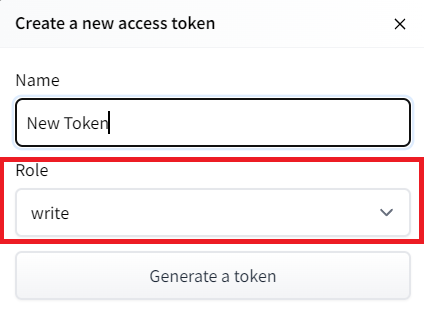

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

### Step 4: Let's start the training 🔥
- Now that you've coded from scratch PPO and added the Hugging Face Integration, we're ready to start the training 🔥

- First, you need to copy all your code to a file you create called `ppo.py`

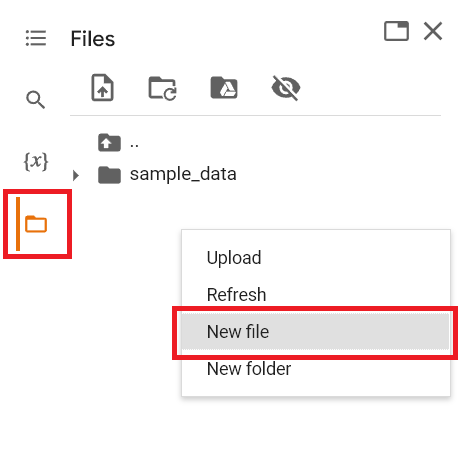

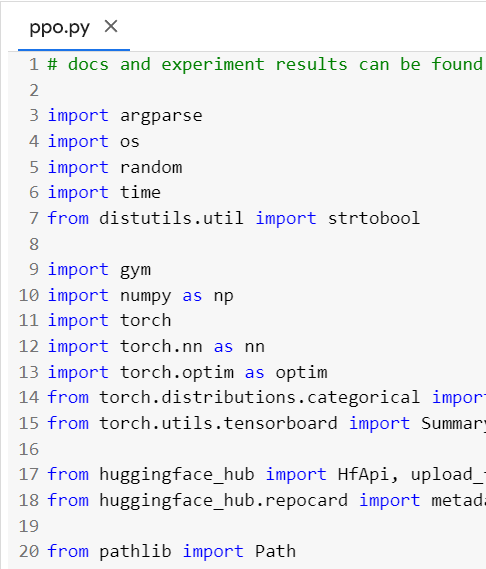

- Now we just need to run this python script using `python <name-of-python-script>.py` with the additional parameters we defined with `argparse`

In [ ]:
!python ppo.py --env-id="LunarLander-v2" --repo-id="YOUR_REPO_ID" --total-timesteps=50000

## Some additional challenges 🏆
In the [Leaderboard](https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard) you will find your agents. Can you get to the top?

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters by looking at what your classmates have done.
* **Push your new trained model** on the Hub 🔥


See you on Next Time! 🔥
## Keep learning, stay awesome 🤗